# **Lung-Nodule-Detection: Part-4 Model Optimization**

## 目标

在Part-4部分，应用 **剪枝** 和 **量化** 的模型优化方法，**统计并对比** 优化前后模型的相关参数。具体目标如下：

- 深入理解 **剪枝** 的原理，实践中提高熟练度，尤其是 ***U-Net*** 的 **跳跃连接** 对剪枝带来的 **复杂度提升**
- 通过统计参数，直观体会 **模型优化** 带来的 **巨大性能提升**，理解其 **重要性**

## 内容

本节主要由2部分组成

- 对 ***U-Net*** 模型进行 **剪枝** 优化，在 ***PC*** 和 ***RK3588S*** 上分别进行部署测试，并统计相关参数。特别是与 **Rockchip** 的 ***SDK*** **自带剪枝算法** 的对比
- 对 ***U-Net*** 模型进行 **量化** 优化，在 ***PC*** 和 ***RK3588S*** 上分别进行部署测试，并统计相关参数。特别是与 **Rockchip** 的 ***SDK*** **自带量化算法** 的对比

## 设置
**必须**先执行一次设置代码块

In [1]:
import os
import sys
import torch
import random
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List
%matplotlib inline

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# 获取当前工作目录
current_path = os.getcwd()

# 获取当前目录的最后一个字符串（即最后一个文件夹名）
last_directory = os.path.basename(current_path)

# 检查是否是 notebook
if last_directory == 'notebooks':
    # 切换到上一级目录
    os.chdir('..')

#print(f"切换到目录: {os.getcwd()}")

sys.path.append('src')  # 将模块所在的路径添加到 sys.path

from util.logconf import logging
from util.profile import *
from optimization.pruning import *
from app.infer.eval_seg import SegmentationTestingApp
from app.train.training_seg import SegmentationTrainingApp

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

2025-05-26 22:18:31.936783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-26 22:18:31.936835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-26 22:18:31.937787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 22:18:31.943754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-26 22:18:32.680870: W tensorflow/compiler/tf2

In [6]:
def train(model):
    seg_training_app = SegmentationTrainingApp(["--epochs=1", "--num-workers=0", '--augmented', '--finetune'], model)
    return seg_training_app.main()

In [2]:
def evaluate(model):
    seg_app = SegmentationTestingApp(["--platform=pytorch", "--num-workers=0"], model)
    return seg_app.eval()

## U-Net 的剪枝优化

首先

In [3]:
print('Before sorting...')
origin_model = load_model()
dense_model_metrics = evaluate(origin_model)
print(dense_model_metrics)

print('After sorting...')
sorted_model = apply_channel_sorting_with_skip(origin_model)
sorted_model_metrics = evaluate(sorted_model)
print(sorted_model_metrics)

# make sure accuracy does not change after sorting, since it is
# equivalent transform
tp_diff = abs(dense_model_metrics['percent_all/tp'] - sorted_model_metrics['percent_all/tp'])
fn_diff = abs(dense_model_metrics['percent_all/fn'] - sorted_model_metrics['percent_all/fn'])
fp_diff = abs(dense_model_metrics['percent_all/fp'] - sorted_model_metrics['percent_all/fp'])
assert tp_diff < 0.1 and fn_diff < 0.1 and fp_diff < 0.1
print('* Check passed.')

#TODO: 输出issues报告，UNet残差连接结构给channel pruning带来的挑战

Before sorting...


eval:   0%|          | 0/7 [00:00<?, ?it/s]

{'loss/all': 0.8376829, 'percent_all/tp': 87.71207332611084, 'percent_all/fn': 12.28792518377304, 'percent_all/fp': 1152.8359413146973, 'pr/precision': 0.070704296, 'pr/recall': 0.87712073, 'pr/f1_score': 0.13086002805331323}
After sorting...


eval:   0%|          | 0/7 [00:00<?, ?it/s]

{'loss/all': 0.8376829, 'percent_all/tp': 87.71207332611084, 'percent_all/fn': 12.28792518377304, 'percent_all/fp': 1152.8359413146973, 'pr/precision': 0.070704296, 'pr/recall': 0.87712073, 'pr/f1_score': 0.13086002805331323}
* Check passed.


In [4]:
model = load_model()
pruned_model = channel_prune(model, 0.3)

dense_model_size = get_model_size(model)
pruned_model_size = get_model_size(pruned_model)

print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
print(f"pruned model has size={pruned_model_size/MiB:.2f} MiB")

dumpy_input = torch.randn(1,7,512,512).to(device)
dumpuy_output = pruned_model(dumpy_input)

dense model has size=0.45 MiB
pruned model has size=0.22 MiB


In [5]:
channel_pruning_ratio = 0.3  # pruned-out ratio

model = load_model()
metrics_dict = evaluate(model)
print(metrics_dict)

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
metrics_dict = evaluate(pruned_model)
print(metrics_dict)

print(" * With sorting...")
sorted_model = apply_channel_sorting_with_skip(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
metrics_dict = evaluate(pruned_model)
print(metrics_dict)

eval:   0%|          | 0/7 [00:00<?, ?it/s]

{'loss/all': 0.8376829, 'percent_all/tp': 87.71207332611084, 'percent_all/fn': 12.28792518377304, 'percent_all/fp': 1152.8359413146973, 'pr/precision': 0.070704296, 'pr/recall': 0.87712073, 'pr/f1_score': 0.13086002805331323}
 * Without sorting...


eval:   0%|          | 0/7 [00:00<?, ?it/s]

{'loss/all': 0.9749099, 'percent_all/tp': 4.166962578892708, 'percent_all/fn': 95.83303928375244, 'percent_all/fp': 303.1447410583496, 'pr/precision': 0.0135594, 'pr/recall': 0.041669626, 'pr/f1_score': 0.02046080336022654}
 * With sorting...


eval:   0%|          | 0/7 [00:00<?, ?it/s]

{'loss/all': 0.9823573, 'percent_all/tp': 0.0, 'percent_all/fn': 100.0, 'percent_all/fp': 0.0, 'pr/precision': 0.0, 'pr/recall': 0.0, 'pr/f1_score': 0.0}


In [7]:
finetuned_pruned_model = train(pruned_model)
metrics = evaluate(finetuned_pruned_model)
print(metrics)

2025-05-26 22:19:14,070 INFO     pid:1654916 app.train.training_seg:164:initModel Using CUDA; 1 devices.
2025-05-26 22:19:15,733 INFO     pid:1654916 app.train.training_seg:228:main Starting SegmentationTrainingApp, Namespace(batch_size=16, num_workers=0, epochs=1, augmented=True, augment_flip=False, augment_offset=False, augment_scale=False, augment_rotate=False, augment_noise=False, tb_prefix='seg', comment='none', finetune=True)
2025-05-26 22:19:16,959 INFO     pid:1654916 core.dsets_seg:281:__init__ <core.dsets_seg.TrainingLuna2dSegmentationDataset object at 0x7f42991f03a0>: 799 training series, 8343 slices, 1028 nodules
2025-05-26 22:19:17,029 INFO     pid:1654916 core.dsets_seg:281:__init__ <core.dsets_seg.Luna2dSegmentationDataset object at 0x7f4299172880>: 89 validation series, 1122 slices, 154 nodules
2025-05-26 22:19:17,030 INFO     pid:1654916 app.train.training_seg:239:main Epoch 1 of 1, 6250/7 batches of size 16*1
2025-05-26 22:19:17,252 WARNING  pid:1654916 util.util:221:

eval:   0%|          | 0/7 [00:00<?, ?it/s]

{'loss/all': 0.90682787, 'percent_all/tp': 86.59757375717163, 'percent_all/fn': 13.402427732944489, 'percent_all/fp': 2581.6993713378906, 'pr/precision': 0.03245425, 'pr/recall': 0.86597574, 'pr/f1_score': 0.06256378890575921}


In [8]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

In [11]:
def show_perf_diff(model, pruned_model):
    table_template = "{:<15} {:<15} {:<15} {:<15}"
    print (table_template.format('', 'Original','Pruned','Reduction Ratio'))
    
    # 1. measure the latency of the original model and the pruned model on GPU
    dummy_input = torch.randn(1, 7, 512, 512).to('cuda')
    pruned_model = pruned_model.to('cuda')
    model = model.to('cuda')
    
    pruned_latency = measure_latency(pruned_model, dummy_input)
    original_latency = measure_latency(model, dummy_input)
    print(table_template.format('Latency (ms)',
                                round(original_latency * 1000, 1),
                                round(pruned_latency * 1000, 1),
                                round(original_latency / pruned_latency, 1)))
    
    # 2. measure the computation (MACs)
    original_macs = get_model_macs(model, dummy_input)
    pruned_macs = get_model_macs(pruned_model, dummy_input)
    print(table_template.format('MACs (M)',
                                round(original_macs / 1e6),
                                round(pruned_macs / 1e6),
                                round(original_macs / pruned_macs, 1)))
    
    # 3. measure the model size (params)
    original_param = get_num_parameters(model)
    pruned_param = get_num_parameters(pruned_model)
    print(table_template.format('Param (M)',
                                round(original_param / 1e6, 2),
                                round(pruned_param / 1e6, 2),
                                round(original_param / pruned_param, 1)))

In [14]:
show_perf_diff(load_model(), finetuned_pruned_model)

                Original        Pruned          Reduction Ratio
Latency (ms)    11.3            7.6             1.5            
MACs (M)        7413            3723            2.0            
Param (M)       0.12            0.06            2.0            


In [6]:
# finetune
# 拿到最好的模型
# 本机测试 latency params MACs
# 部署到平台测试
# 与SDK剪枝对比

In [1]:
plot_weight_distribution(model)

NameError: name 'plot_weight_distribution' is not defined

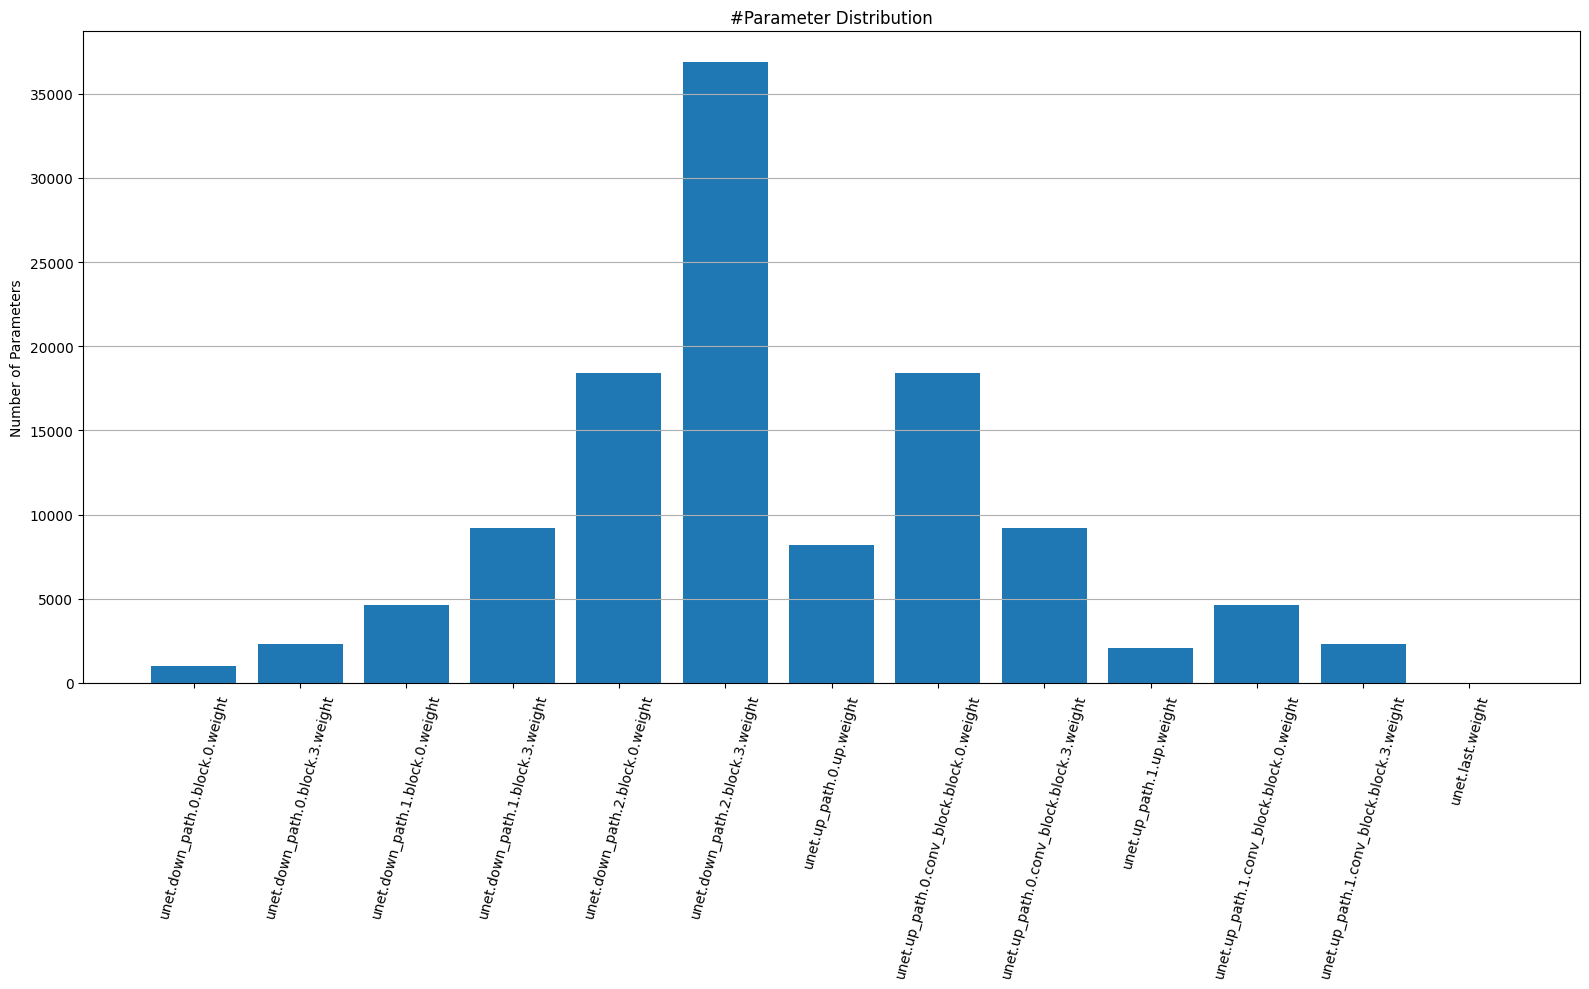

In [5]:
plot_num_parameters_distribution(model)